# Pipeline updates

#### Sentinel2

Basic functions

In [18]:
import rasterio
import numpy as np
from skimage.measure import label, regionprops
import torch
import matplotlib.pyplot as plt

def process_mask(mask: np.ndarray, bands: int = 1) -> np.ndarray:
    intermediary_mask = np.where(mask > 0, 255, 0).astype(np.uint8)
    # If single band, convert to 3 band
    if bands == 3 and (len(intermediary_mask.shape) == 2 or 1 in intermediary_mask.shape):
        return np.stack((intermediary_mask,) * 3, axis=-1)
    return intermediary_mask


def get_bboxes(mask: np.ndarray) -> np.ndarray:    
    # Ensure mask is a numpy array if it's a torch tensor
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()

    # If the mask has more than 2 dimensions (e.g., a color image), we need to reduce it to 2D
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = np.squeeze(mask)
    elif len(mask.shape) == 3 and mask.shape[0] > 1:
        raise ValueError("Mask has more than one channel. Please provide a single-channel mask. We haven't built this for multichannel masks yet.")

    # Label connected components in the mask
    labeled_mask = label(mask == 255)

    # Get properties of labeled regions (connected components)
    props = regionprops(labeled_mask)

    # Extract bounding boxes
    bounding_boxes = []
    for prop in props:
        ymin, xmin, ymax, xmax = prop.bbox
        bounding_boxes.append((xmin, ymin, xmax, ymax))

    return bounding_boxes


def side_by_side(image_set_1, image_set_2):
    for image1, image2 in zip(image_set_1, image_set_2):
        plt.figure(figsize=(6, 3))
        
        # Original mask
        plt.subplot(1, 2, 1)
        plt.imshow(image1, cmap="gray")
        plt.title("Original Mask")
        plt.axis("off")
        
        # Processed mask
        plt.subplot(1, 2, 2)
        plt.imshow(image2, cmap="gray")
        plt.title("Processed Mask")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

In [ ]:
import os
from glob import glob

def make_255(image: np.ndarray) -> np.ndarray:
    return np.where(image > 0, 255, 0).astype(np.uint8)

image_paths = glob("test_images/*.tif")[:5]

test_images = []
for image_path in image_paths:
    test_images.append(make_255(rasterio.open(image_path, driver="GTiff", mode='r').read()))

Visual preprocessing goes here

In [20]:
import numpy as np
from skimage.morphology import opening, closing, disk
import matplotlib.pyplot as plt

def preprocess_mask(mask: np.ndarray, opening_disk_size: int = 2, closing_disk_size: int = 2) -> np.ndarray:
    # """
    # USELESS FUNCTION THAT NEVER WORKED YESTERDAY NO MATTER WHAT I DID SO I GAVE UP ON IT
    
    pass


Print the generated bounding boxes

In [21]:
bbox_set = []
for image in test_images:
    bbox_set.append([list(bbox) for bbox in get_bboxes(image)])

print(*bbox_set, sep="\n")
print([len(bboxes) for bboxes in bbox_set])

[[2, 202, 6, 205], [6, 206, 14, 211], [15, 212, 17, 213], [8, 215, 9, 216], [20, 215, 21, 216], [13, 217, 14, 218], [27, 220, 38, 227], [26, 225, 31, 228], [39, 227, 41, 229], [44, 229, 53, 236], [38, 232, 45, 237], [46, 237, 49, 239], [54, 237, 58, 240], [59, 240, 63, 243], [54, 243, 55, 244], [66, 244, 69, 247], [58, 245, 59, 246], [62, 248, 66, 251], [71, 248, 75, 250], [69, 253, 73, 256], [82, 255, 85, 256]]
[[177, 0, 187, 4], [192, 6, 200, 13], [202, 15, 206, 17], [206, 18, 211, 23], [212, 22, 233, 34], [218, 30, 219, 31], [222, 32, 225, 34], [238, 38, 245, 42], [250, 44, 256, 48]]
[[7, 54, 13, 57], [23, 63, 26, 65], [28, 67, 38, 73], [41, 75, 60, 87], [64, 87, 65, 89], [72, 93, 88, 103], [87, 105, 91, 108], [98, 113, 113, 124], [115, 122, 130, 132], [133, 135, 135, 136], [136, 136, 161, 155], [163, 155, 175, 165], [175, 164, 189, 175], [192, 178, 196, 181], [206, 188, 208, 189], [209, 189, 219, 196], [220, 196, 225, 202], [226, 201, 232, 208], [233, 207, 245, 215], [245, 216, 251

Box merging

In [22]:
from Web.BE.functions import merge_overlapping_boxes

# Remove microboxes (i.e., boxes with an area less than 0.1% of the image size)
def remove_microboxes(boxes, size):
    image_area = size[0] * size[1]
    min_area_threshold = int((0.01/100) * image_area)
    # return [box for box in boxes if abs((box[2] - box[0]) * (box[3] - box[1])) >= min_area_threshold]
    saved_boxes = []
    for box in boxes:
        area = abs((box[2] - box[0]) * (box[3] - box[1]))
        if area >= min_area_threshold:
            saved_boxes.append(box)
    return saved_boxes

slimmed_boxes = []
for bboxes in bbox_set:
    # temp = remove_microboxes(bboxes, (256, 256))
    slimmed_boxes.append(merge_overlapping_boxes(bboxes))

print([len(bboxes) for bboxes in slimmed_boxes])

[20, 7, 21, 10, 41]


Pseudocode planned yesterday goes here

In [56]:
import numpy as np
from typing import List

def final_filter_bboxes(image: np.ndarray, bboxes: List) -> List:
    """For each bbox, finds the true size of the object in pixels.
    Once it finds the size, it removes the bbox if the object is too small.

    Args:
        image (np.ndarray): The image to filter bboxes from.
        bboxes (List): Set of bounding boxes for the image, technically type List[List[int]]

    Returns:
        List: List of reduced bounding boxes.
    """
    new_bboxes = []
    new_image = image.copy()
    clump_areas = 0
    counter = 0
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        object = new_image[ymin:ymax, xmin:xmax]  # Isolate the object
        whites = np.sum(object == 255)
        if whites < 5:
            new_image[ymin:ymax, xmin:xmax] = 0
            continue
        if whites > 15:
            new_bboxes.append([chr(counter + 97), whites, *bbox])
        else:
            clump_areas += whites
        counter += 1
    new_bboxes.append(["clump", clump_areas, 0, 0, 0, 0])
    return new_image, new_bboxes

new_images = []
new_bbox_set = []
for image, bboxes in zip(test_images, slimmed_boxes):
    new_image, new_bboxes = final_filter_bboxes(image[0], bboxes)
    new_images.append(new_image)
    new_bbox_set.append(new_bboxes)
    print(len(new_bboxes) - 1)

3
3
11
5
7


Visualisation

(1, 256, 256) (256, 256)


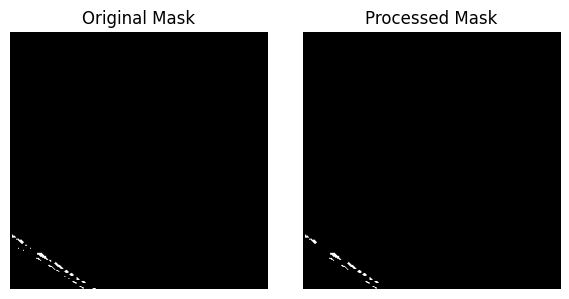

(1, 256, 256) (256, 256)


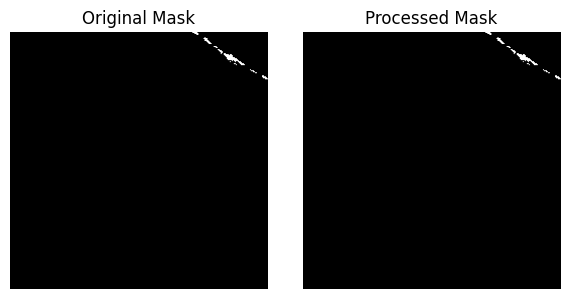

(1, 256, 256) (256, 256)


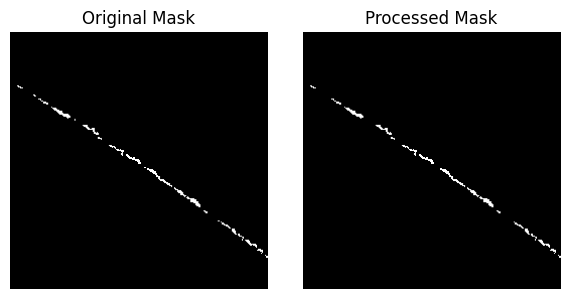

(1, 256, 256) (256, 256)


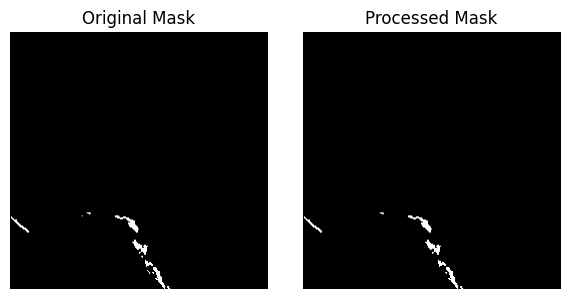

(1, 256, 256) (256, 256)


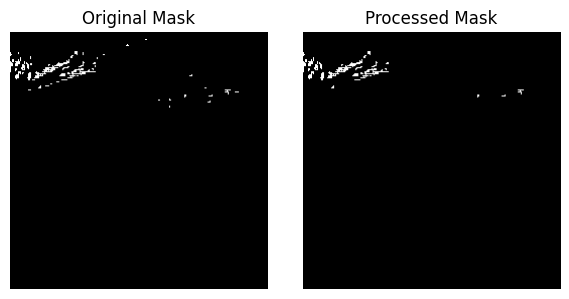

In [57]:
for image, new_image in zip(test_images, new_images):
    print(image.shape, new_image.shape)
    side_by_side(image, [new_image])

Clumpy area: 57


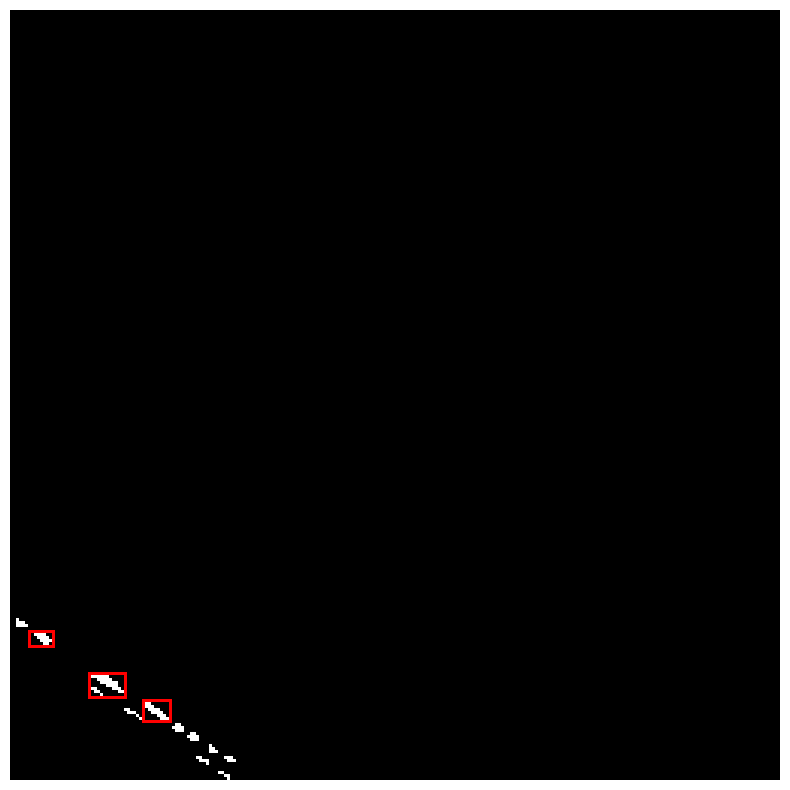

Clumpy area: 37


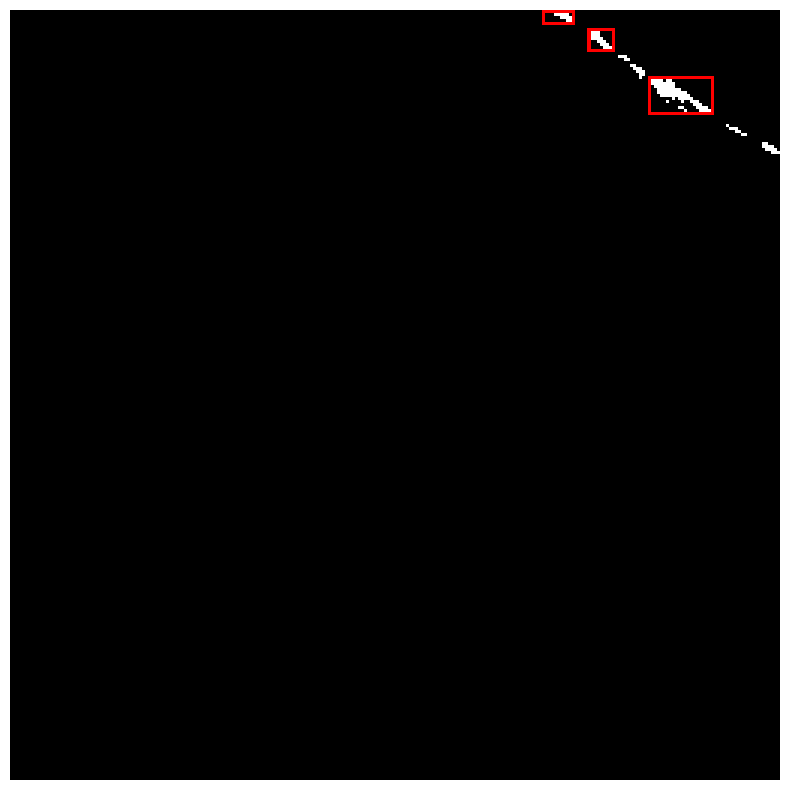

Clumpy area: 53


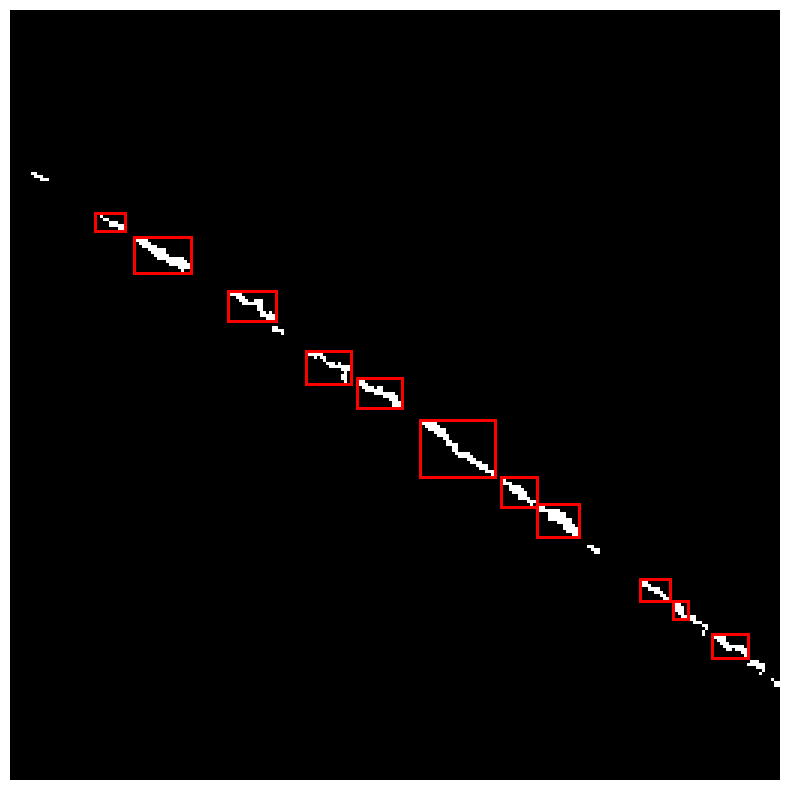

Clumpy area: 12


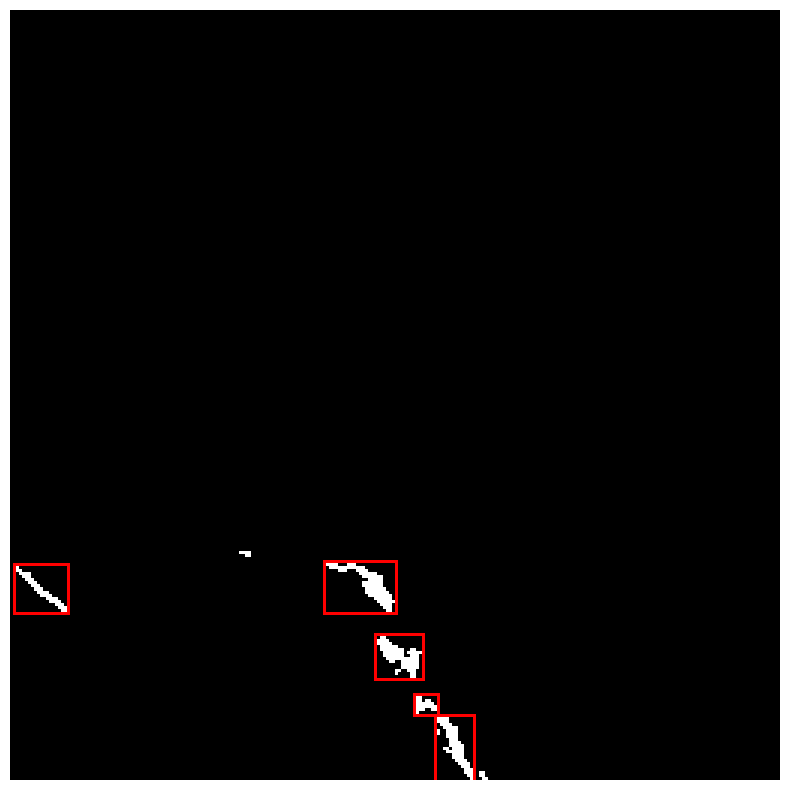

Clumpy area: 89


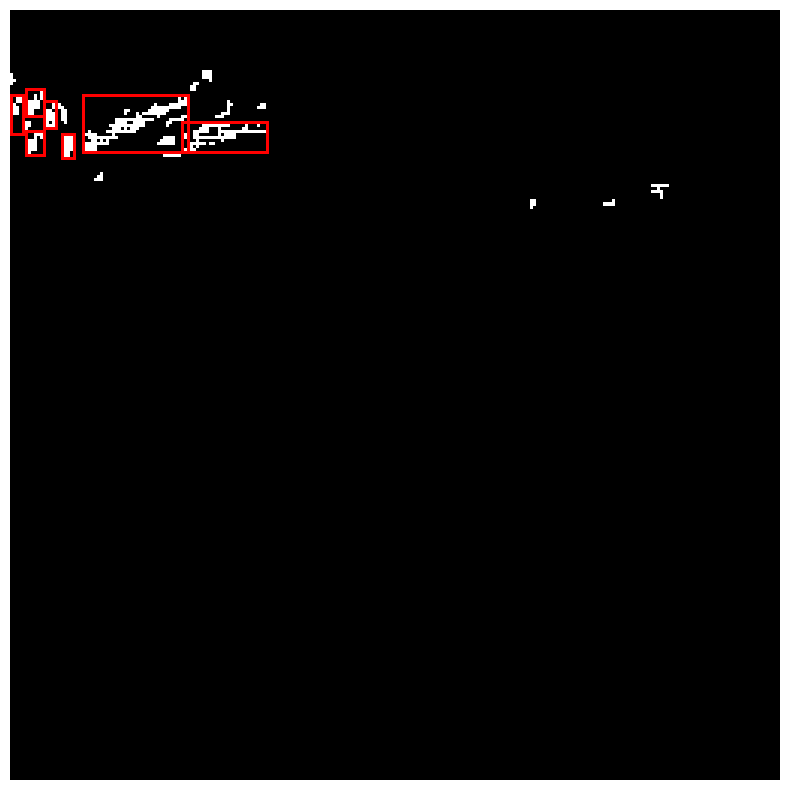

In [ ]:
import matplotlib.pyplot as plt
from typing import List
import cv2

def draw_yolo_boxes(image: np.ndarray, bboxes: List[List[float]]) -> np.ndarray:
    """Function to draw YOLO boxes on the image.

    Args:
        image (np.ndarray): Image array.
        bboxes (List[List[int]]): List of lists containing bboxes and class name.

    Returns:
        np.ndarray: Image array with boxes drawn.
    """
    for bbox in bboxes:
        _, _, x1, y1, x2, y2 = bbox
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    return image


for image, bboxes in zip(new_images, new_bbox_set):
    if image.shape[0] == 1:
        image = np.stack((image[0],) * 3, axis=-1)
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    plt.figure(figsize=(10, 10))
    print(f"Clumpy area: {bboxes[-1][1]}")
    plt.imshow(draw_yolo_boxes(image, bboxes[:-1]))
    plt.axis("off")
    plt.show()